# Taller de Recuperación Texto-Imagen (Image Retrieval)

## Objetivos:
1. Implementar un sistema de recuperación texto-imagen usando CLIP
2. Usar el dataset Caltech 256 (20%-50% de imágenes aleatorias)
3. Crear una interfaz interactiva para búsquedas
4. Evaluar el rendimiento del sistema

## Dataset: Caltech 256
- Web: https://data.caltech.edu/records/nyy15-4j048
- 256 categorías de objetos
- ~30,607 imágenes totales
- Mínimo 80 imágenes por categoría


## 1. Configuración del Entorno


In [1]:
# Instalar dependencias
#%pip install pip install transformers torch datasets streamlit faiss-cpu


In [2]:
import os
import random
import numpy as np
from PIL import Image
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import random
from transformers import CLIPProcessor, CLIPModel
import torch

In [3]:

# Configurar semilla para reproducibilidad
random.seed(42)

## 2. Carga del Dataset y EDA basico


In [4]:

# Ruta al dataset Caltech 256
dataset_path = "256_ObjectCategories"

# Función para cargar el dataset Caltech 256 con muestra aleatoria
def load_caltech256_sample(dataset_path, sample_percentage=0.2):
    """
    Carga una muestra aleatoria del dataset Caltech 256
    
    Args:
        dataset_path: Ruta al dataset
        sample_percentage: Porcentaje de imágenes a muestrear (0.2 = 20%, 0.5 = 50%)
    
    Returns:
        Dataset de Hugging Face con imágenes y categorías
    """
    images = []
    categories = []
    category_names = []
    
    # Obtener todas las categorías
    category_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    category_dirs.sort()  # Ordenar para consistencia
    
    print(f"Encontradas {len(category_dirs)} categorías")
    
    for category_dir in category_dirs:
        category_path = os.path.join(dataset_path, category_dir)
        
        # Obtener nombre de la categoría (remover número y punto)
        category_name = category_dir.split('.', 1)[1] if '.' in category_dir else category_dir
        
        # Quitar sufijo "-101" y reemplazar guiones por espacios
        if category_name.endswith('-101'):
            category_name = category_name[:-4]  # Quitar "-101"
        category_name = category_name.replace('-', ' ')  # Reemplazar guiones por espacios
        
        # Obtener todas las imágenes en la categoría
        image_files = [f for f in os.listdir(category_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Calcular cuántas imágenes muestrear
        num_images = len(image_files)
        sample_size = max(1, int(num_images * sample_percentage))
        
        # Muestrear aleatoriamente
        sampled_images = random.sample(image_files, min(sample_size, num_images))
        
        # Cargar las imágenes muestreadas
        for img_file in sampled_images:
            img_path = os.path.join(category_path, img_file)
            try:
                # Cargar imagen
                image = Image.open(img_path).convert('RGB')
                
                # Agregar a las listas
                images.append(image)
                categories.append(category_dir)  # ID numérico de la categoría
                category_names.append(category_name)  # Nombre descriptivo
                
            except Exception as e:
                print(f"Error cargando {img_path}: {e}")
                continue
    
    print(f"\nTotal de imágenes cargadas: {len(images)}")
    
    # Crear dataset de Hugging Face
    dataset = Dataset.from_dict({
        "image": images,
        "category_id": categories,
        "category_name": category_names
    })
    
    return dataset

# Cargar dataset con 30% de las imágenes (puedes cambiar este porcentaje)
print("Cargando dataset Caltech 256...")
caltech_dataset = load_caltech256_sample(dataset_path, sample_percentage=0.3)

print(f"\nDataset creado con {len(caltech_dataset)} ejemplos")
print(f"Características del dataset: {caltech_dataset.features}")


Cargando dataset Caltech 256...
Encontradas 257 categorías

Total de imágenes cargadas: 9076

Dataset creado con 9076 ejemplos
Características del dataset: {'image': Image(mode=None, decode=True), 'category_id': Value('string'), 'category_name': Value('string')}


=== EXPLORACIÓN DEL DATASET ===
Número total de ejemplos: 9076

Número de categorías únicas: 257
Promedio de imágenes por categoría: 35.3

Top 10 categorías con más imágenes:
  clutter: 248 imágenes
  airplanes: 240 imágenes
  motorbikes: 239 imágenes
  faces easy: 130 imágenes
  t shirt: 107 imágenes
  hammock: 85 imágenes
  billiards: 83 imágenes
  horse: 81 imágenes
  ladder: 72 imágenes
  bathtub: 69 imágenes

=== ANÁLISIS DE TAMAÑOS ===
Tamaño promedio: 370x325
Rango de anchos: 75-3424
Rango de alturas: 75-3468


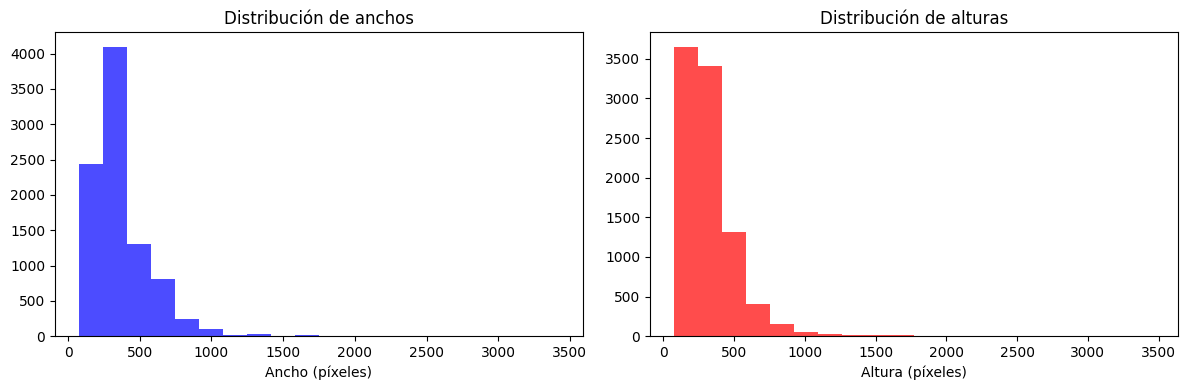

In [5]:
# Explorar el dataset
print("=== EXPLORACIÓN DEL DATASET ===")
print(f"Número total de ejemplos: {len(caltech_dataset)}")

# Mostrar estadísticas por categoría
category_counts = {}
for example in caltech_dataset:
    cat_name = example['category_name']
    category_counts[cat_name] = category_counts.get(cat_name, 0) + 1

print(f"\nNúmero de categorías únicas: {len(category_counts)}")
print(f"Promedio de imágenes por categoría: {len(caltech_dataset) / len(category_counts):.1f}")

# Mostrar las categorías con más imágenes
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 10 categorías con más imágenes:")
for cat, count in sorted_categories[:10]:
    print(f"  {cat}: {count} imágenes")

# Análisis de tamaños de imágenes
print(f"\n=== ANÁLISIS DE TAMAÑOS ===")
widths, heights = [], []
for example in caltech_dataset:
    w, h = example['image'].size
    widths.append(w)
    heights.append(h)

print(f"Tamaño promedio: {sum(widths)/len(widths):.0f}x{sum(heights)/len(heights):.0f}")
print(f"Rango de anchos: {min(widths)}-{max(widths)}")
print(f"Rango de alturas: {min(heights)}-{max(heights)}")

# Distribución de tamaños
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(widths, bins=20, alpha=0.7, color='blue')
ax1.set_title('Distribución de anchos')
ax1.set_xlabel('Ancho (píxeles)')
ax2.hist(heights, bins=20, alpha=0.7, color='red')
ax2.set_title('Distribución de alturas')
ax2.set_xlabel('Altura (píxeles)')
plt.tight_layout()
plt.show()

Visualizando muestras aleatorias del dataset Caltech 256:


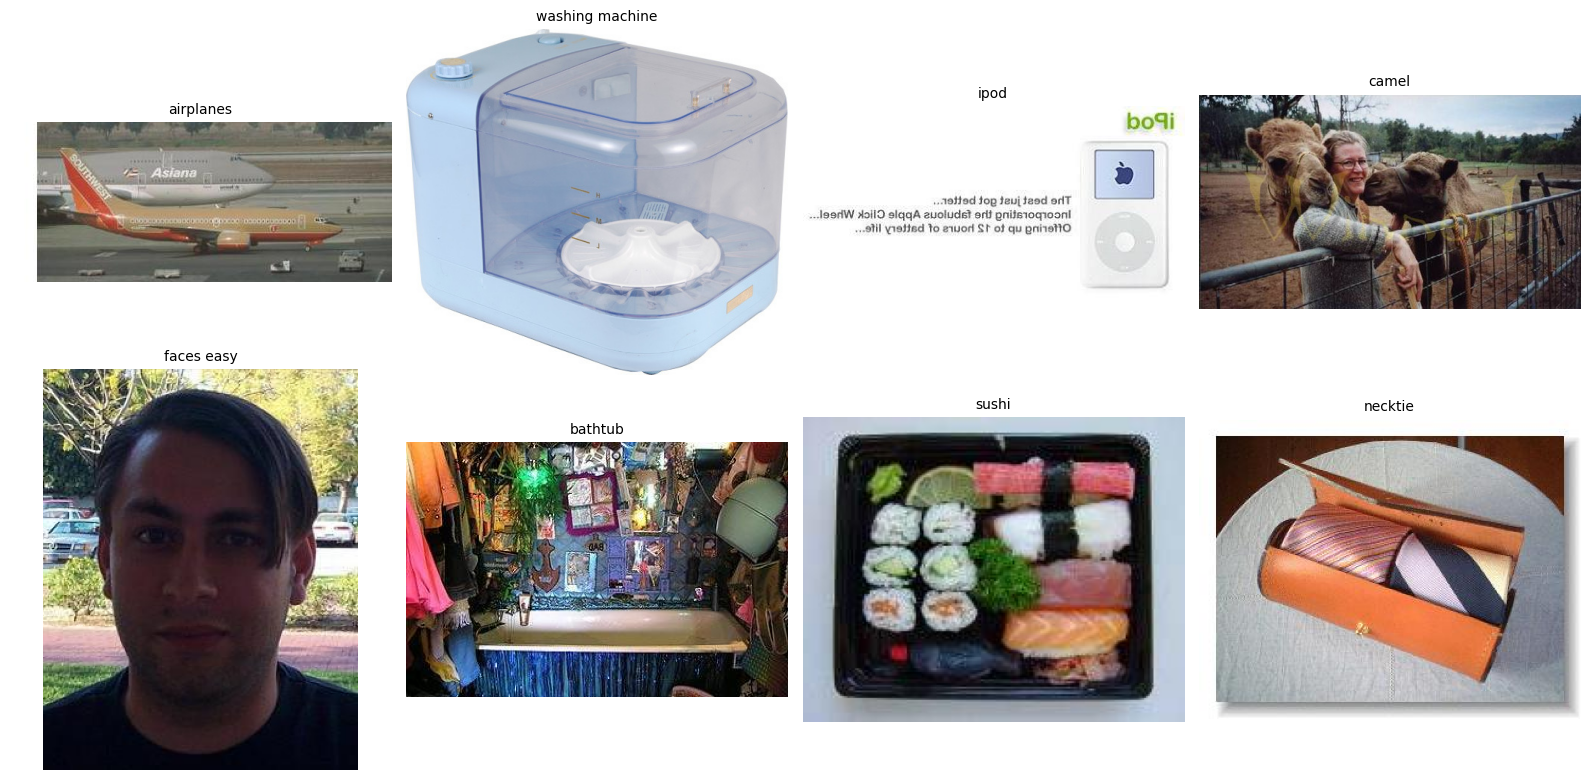

In [6]:
# Visualizar algunas imágenes del dataset

def visualize_dataset_samples(dataset, num_samples=8):
    """
    Visualiza una muestra aleatoria de imágenes del dataset
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Seleccionar índices aleatorios
    random_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for i, idx in enumerate(random_indices):
        example = dataset[idx]
        image = example['image']
        category = example['category_name']
        
        axes[i].imshow(image)
        axes[i].set_title(f"{category}", fontsize=10)
        axes[i].axis('off')
    
    # Ocultar ejes vacíos
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar muestras del dataset
print("Visualizando muestras aleatorias del dataset Caltech 256:")
visualize_dataset_samples(caltech_dataset, num_samples=8)


## 3. Carga del Modelo CLIP y Extracción de Características


https://www-pinecone-io.translate.goog/learn/series/image-search/clip/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc&_x_tr_hist=true

In [7]:
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

### Codificación de texto

In [8]:
# Convertir la columna a lista de strings
text = list(caltech_dataset['category_name'])

tokens = processor(
    text=text[:100],
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [9]:
text_emb = model.get_text_features(
    **tokens
)

In [10]:
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

torch.Size([100, 512])
tensor(-2.2352, grad_fn=<MinBackward1>) tensor(6.3234, grad_fn=<MaxBackward1>)


In [11]:
# IF using dot product similarity, must normalize vectors like so...
# detach text emb from graph, move to CPU, and convert to numpy array
text_emb = text_emb.detach().cpu().numpy()

# calculate value to normalize each vector by
norm_factor = np.linalg.norm(text_emb, axis=1)
norm_factor.shape

(100,)

In [12]:
text_emb = text_emb.T / norm_factor
# transpose back
text_emb = text_emb.T
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

(100, 512)
-0.22655708 0.58536965


### Codificación de imágenes

In [13]:
caltech_dataset['image'][0].size

# Convertir la columna de imágenes a lista
image_batch = list(caltech_dataset['image'])

images = processor(
    text=None,
    images=image_batch[:100],
    return_tensors='pt'
)['pixel_values'].to(device)
images.shape

torch.Size([100, 3, 224, 224])

In [14]:
img_emb = model.get_image_features(images)
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

torch.Size([100, 512])
tensor(-9.3516, grad_fn=<MinBackward1>) tensor(2.7684, grad_fn=<MaxBackward1>)


In [15]:
# NORMALIZE
# detach text emb from graph, move to CPU, and convert to numpy array
img_emb = img_emb.detach().cpu().numpy()

img_emb = img_emb.T / np.linalg.norm(img_emb, axis=1)
# transpose back to 
img_emb = img_emb.T
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

(100, 512)
-0.73739946 0.24632972


### Cálculo de similitud

In [16]:
from numpy.linalg import norm

cos_sim = np.dot(text_emb, img_emb.T) / (
    norm(text_emb, axis=1) * norm(img_emb, axis=1)
)
cos_sim.shape

(100, 100)

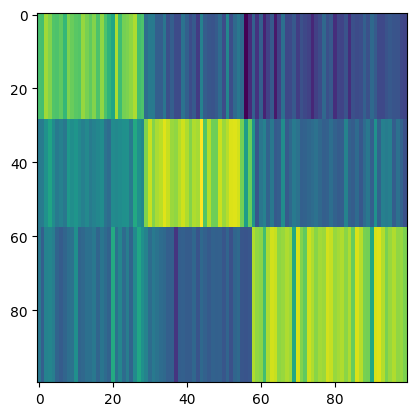

In [17]:
plt.imshow(cos_sim)
plt.show()

## 4. Implementación del Sistema de Recuperación


In [18]:
# Implementar un sistema de recuperación texto-imagen usando CLIP con FAISS
from image_retrieval_system import CLIPImageRetrievalSystem

# Crear instancia del sistema
print("Inicializando sistema de recuperación CLIP...")
retrieval_system = CLIPImageRetrievalSystem()


Inicializando sistema de recuperación CLIP...
Cargando modelo CLIP: openai/clip-vit-base-patch32
Modelo cargado en dispositivo: cpu


In [19]:
# Construir el índice FAISS con el dataset Caltech 256
print("Construyendo índice FAISS para el dataset...")
retrieval_system.build_index(caltech_dataset)

print(f"\nSistema de recuperación listo!")
print(f"Total de imágenes indexadas: {len(retrieval_system.metadata)}")
print(f"Dimensiones de embeddings: {retrieval_system.image_embeddings.shape[1]}")


Construyendo índice FAISS para el dataset...
Construyendo índices FAISS...
Extrayendo embeddings de 9076 imágenes...


100%|██████████| 284/284 [02:08<00:00,  2.21it/s]


Embeddings de imágenes extraídos: (9076, 512)
Extrayendo embeddings de 9076 textos...


100%|██████████| 284/284 [00:04<00:00, 57.68it/s]


Embeddings de texto extraídos: (9076, 512)
Índices construidos:
  - Imágenes: 9076 embeddings
  - Textos: 9076 embeddings

Sistema de recuperación listo!
Total de imágenes indexadas: 9076
Dimensiones de embeddings: 512


In [20]:
# Guardar y cargar índices

def save_retrieval_system(system, filepath="index/caltech256_clip_index"):
    """
    Guardar el sistema de recuperación completo
    """
    print(f"Guardando sistema de recuperación en {filepath}...")
    system.save_index(filepath)
    print("Sistema guardado exitosamente")

def load_retrieval_system(filepath="clip_retrieval_index"):
    """
    Cargar un sistema de recuperación guardado
    """
    print(f"Cargando sistema de recuperación desde {filepath}...")
    
    # Crear nueva instancia del sistema
    loaded_system = CLIPImageRetrievalSystem()
    loaded_system.load_index(filepath)
    
    print("Sistema cargado exitosamente")
    return loaded_system

# Guardar el sistema actual
save_retrieval_system(retrieval_system, "index/caltech256_clip_index")


Guardando sistema de recuperación en index/caltech256_clip_index...
Guardando índices en index/caltech256_clip_index...
Índices guardados exitosamente
Sistema guardado exitosamente


## 5. Interfaz Interactiva de Búsqueda


## 🚀 Instrucciones de Ejecución

### 1. Configuración del Entorno Virtual

```bash
# Navegar al directorio del proyecto
cd /Users/andrestrepo/Documents/repos_personal/vision_aplicada

# Activar el entorno virtual
source .venv/bin/activate
```

### 2. Instalación de Dependencias

```bash
# Navegar al directorio del taller
cd taller_clase_3

# Instalar las dependencias requeridas
pip install -r requirements.txt
```

### 3. Ejecutar el Notebook (Primer Paso)

```bash
# Ejecutar todas las celdas del notebook para generar los índices
jupyter notebook taller_recuperacion_imagenes.ipynb
```

**⚠️ Importante:** Debes ejecutar todo el notebook primero para generar los archivos de índice necesarios.

### 4. Ejecutar la Aplicación Streamlit

#### Opción A: Usando el script optimizado (Recomendado)

```bash
# Usar el script de ejecución optimizado
python run_app.py
```

#### Opción B: Ejecución directa

```bash
# Ejecutar directamente con Streamlit
streamlit run ui_streamlit.py
```

### 5. Acceder a la Aplicación

- La aplicación se abrirá automáticamente en tu navegador
- URL por defecto: `http://localhost:8501`
- Si no se abre automáticamente, copia y pega la URL en tu navegador

### 6. Funcionalidades Disponibles

- **🔍 Búsqueda por texto**: Escribe una descripción y encuentra imágenes similares
- **🖼️ Búsqueda por imagen**: Sube una imagen y encuentra otras similares
- **📊 Exploración del dataset**: Navega por las categorías del dataset Caltech 256
- **📈 Evaluación del sistema**: Prueba la precisión del sistema de recuperación

### 7. Notas Importantes

- ✅ Asegúrate de tener el dataset Caltech 256 descargado en la carpeta `256_ObjectCategories/`
- ✅ La primera ejecución puede tardar más tiempo debido a la descarga de modelos
- ✅ Para detener la aplicación, presiona `Ctrl+C` en la terminal
- ✅ Si hay errores, revisa que todos los archivos de índice se hayan generado correctamente

### 8. Estructura de Archivos Requeridos

```
taller_clase_3/
├── 256_ObjectCategories/          # Dataset Caltech 256
├── index/                         # Índices generados (después de ejecutar notebook)
│   ├── caltech256_clip_index_image.index
│   ├── caltech256_clip_index_text.index
│   ├── caltech256_clip_index_image_embeddings.npy
│   ├── caltech256_clip_index_text_embeddings.npy
│   └── caltech256_clip_index_metadata.pkl
├── ui_streamlit.py               # Interfaz Streamlit
├── image_retrieval_system.py     # Sistema de recuperación
├── run_app.py                    # Script de ejecución optimizado
└── requirements.txt              # Dependencias
```


![imagen_ui](sistema_recuperacion.png)

## 6. Análisis de Categorías y Búsquedas Específicas


=== EJEMPLOS DE BÚSQUEDA POR TEXTO ===
Buscando imágenes para: 'dog'
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 84.98it/s]

Embeddings de texto extraídos: (1, 512)

Encontrados 6 resultados:
  1. fire hydrant (Score: 0.285)
  2. dog (Score: 0.284)
  3. ladder (Score: 0.283)
  4. greyhound (Score: 0.278)
  5. greyhound (Score: 0.276)
  6. greyhound (Score: 0.276)


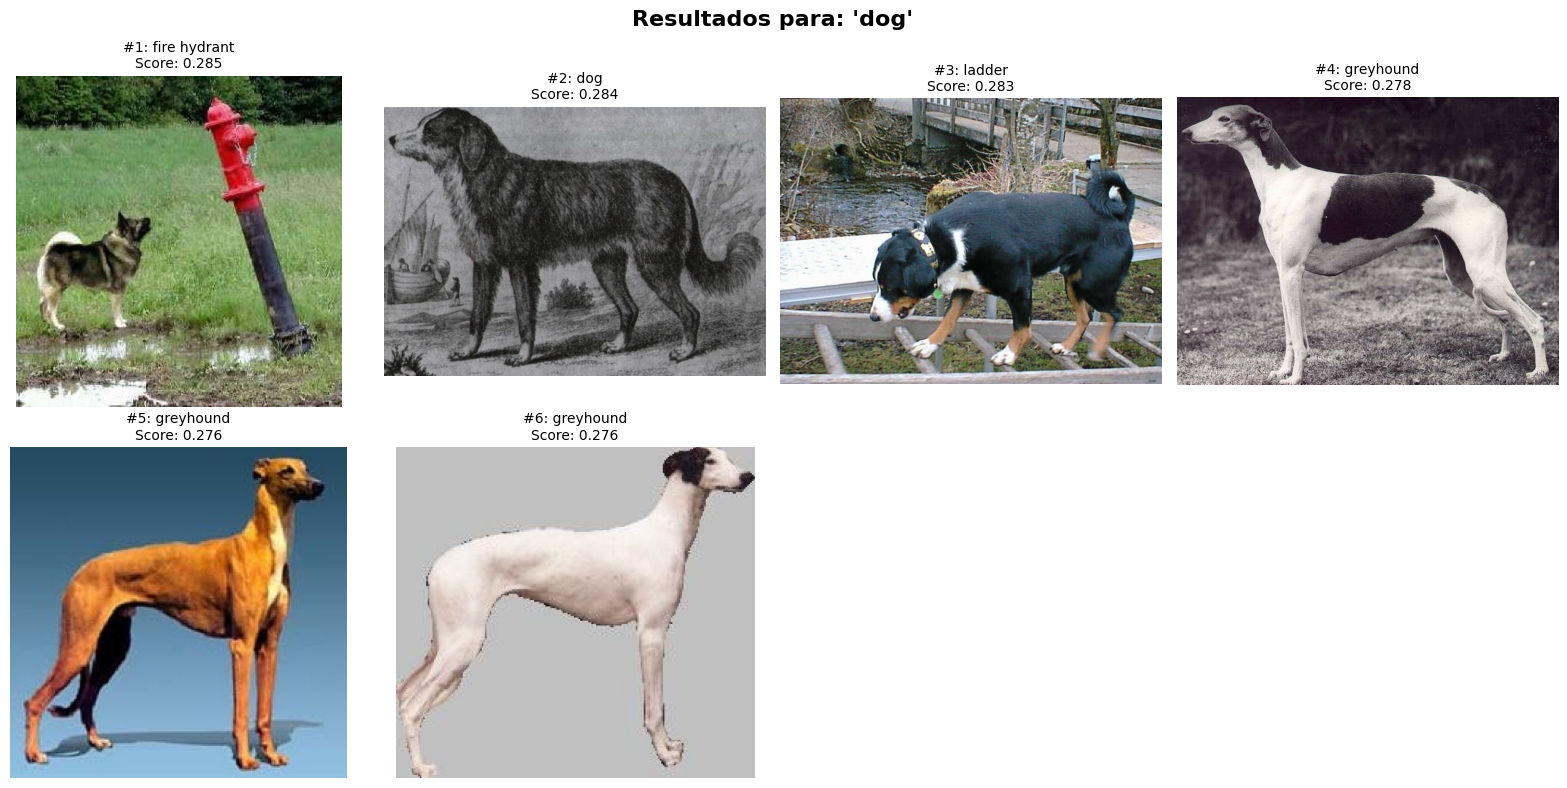

In [21]:
# Ejemplos de búsqueda por texto

print("=== EJEMPLOS DE BÚSQUEDA POR TEXTO ===")

# Ejemplo 1: Buscar animales
retrieval_system.search_and_visualize_text("dog", k=6)

Buscando imágenes para: 'car'
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 80.92it/s]

Embeddings de texto extraídos: (1, 512)

Encontrados 6 resultados:
  1. steering wheel (Score: 0.287)
  2. steering wheel (Score: 0.285)
  3. steering wheel (Score: 0.283)
  4. license plate (Score: 0.281)
  5. car side (Score: 0.281)
  6. steering wheel (Score: 0.280)


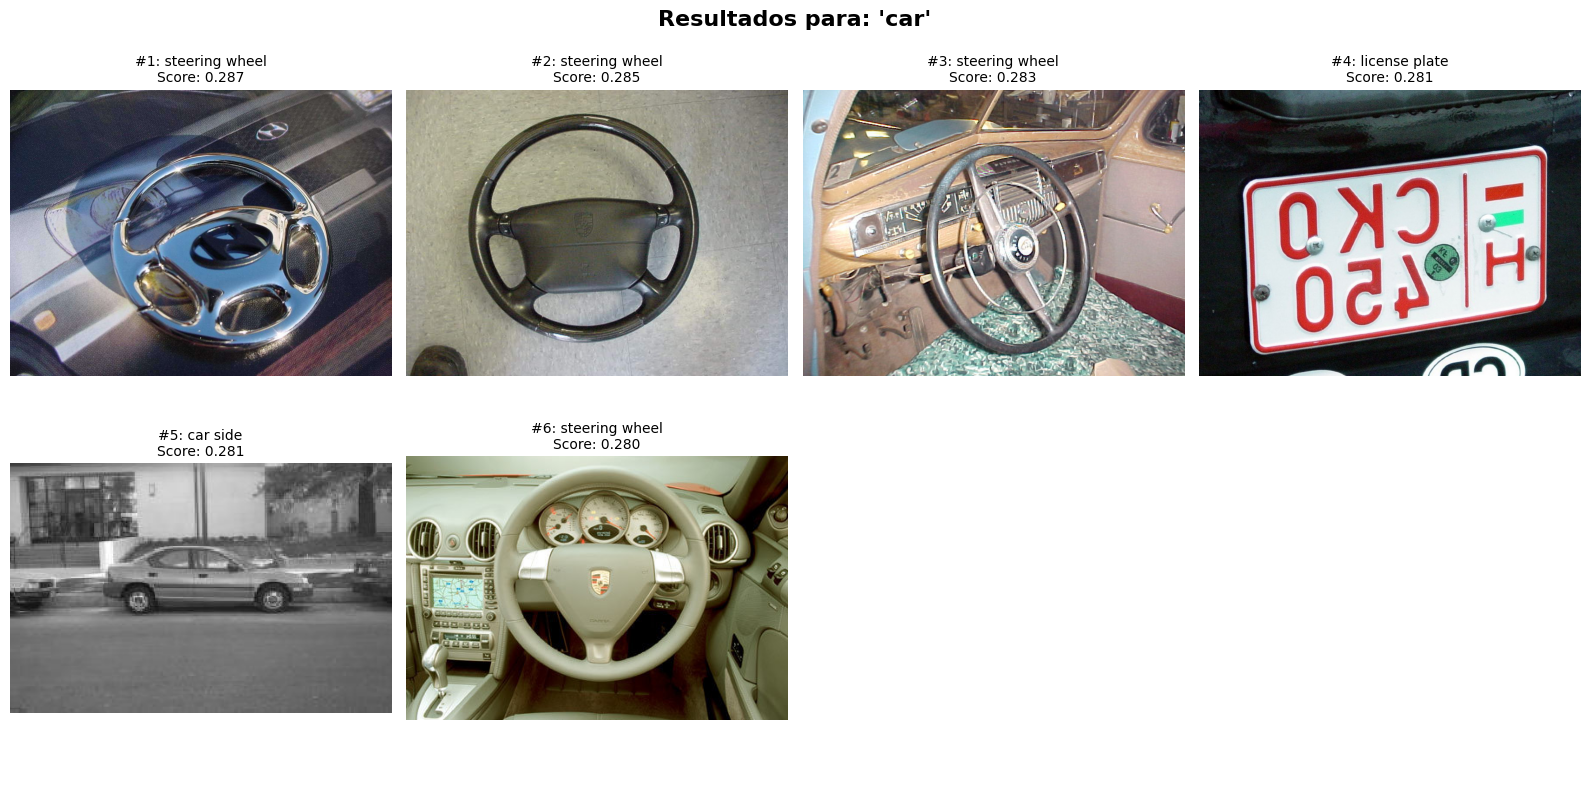

In [22]:
# Ejemplo 2: Buscar vehículos
retrieval_system.search_and_visualize_text("car", k=6)

=== EJEMPLO DE BÚSQUEDA POR IMAGEN ===
Imagen de consulta: Categoría 'clutter' (índice 9064)
Buscando imágenes similares...
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 35.99it/s]

Embeddings de imágenes extraídos: (1, 512)

Encontrados 6 resultados:
  1. clutter (Score: 1.000)
  2. cactus (Score: 0.871)
  3. cactus (Score: 0.838)
  4. fern (Score: 0.836)
  5. clutter (Score: 0.834)
  6. clutter (Score: 0.830)


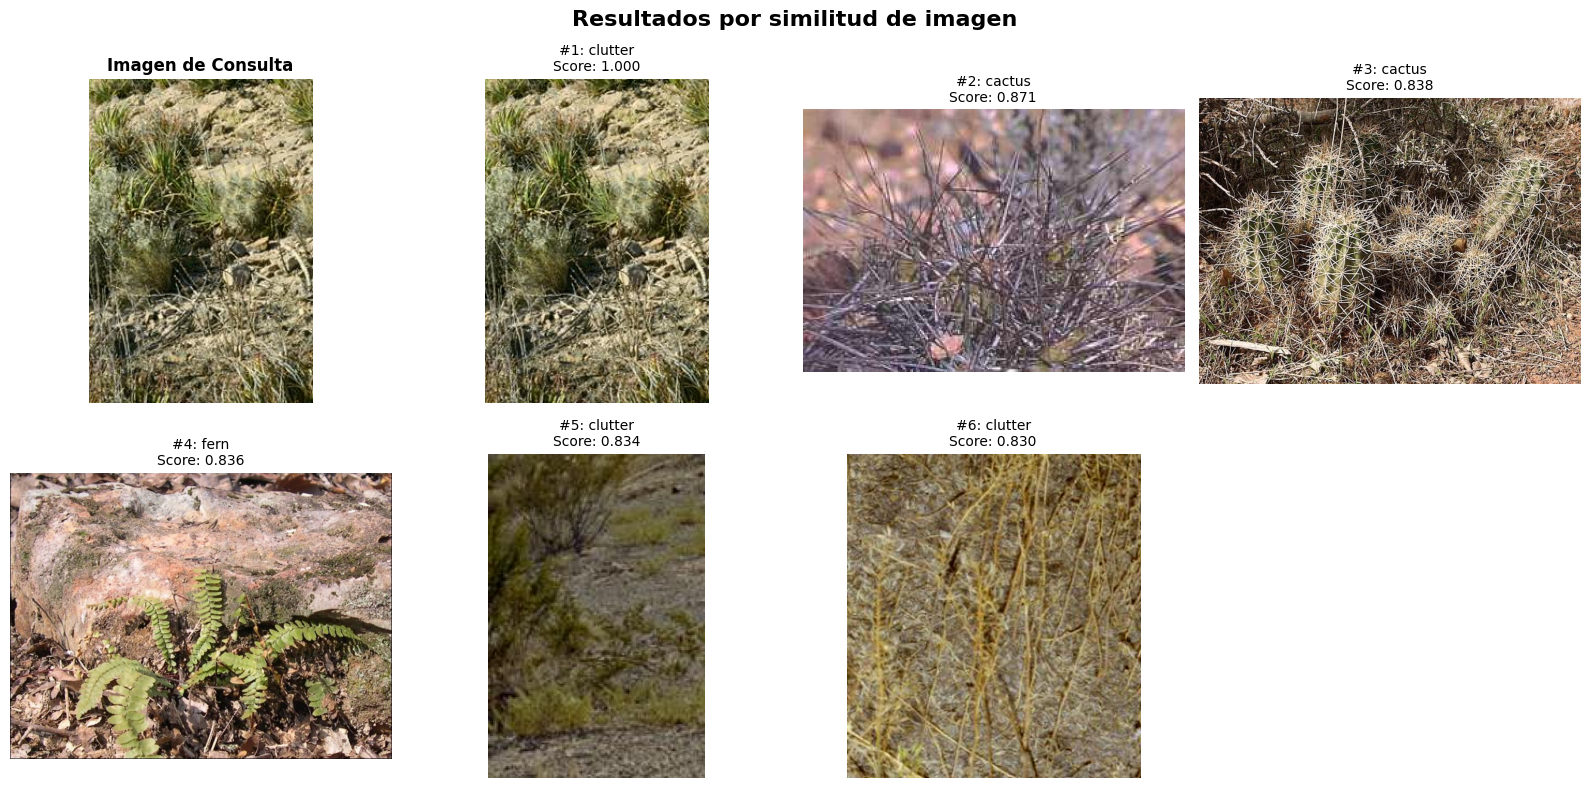

In [23]:
# Ejemplo 4: Búsqueda por imagen
print("=== EJEMPLO DE BÚSQUEDA POR IMAGEN ===")

# Seleccionar una imagen aleatoria del dataset como consulta
import random
query_idx = random.randint(0, len(caltech_dataset)-1)
query_image = caltech_dataset[query_idx]['image']
query_category = caltech_dataset[query_idx]['category_name']

print(f"Imagen de consulta: Categoría '{query_category}' (índice {query_idx})")

# Buscar imágenes similares
retrieval_system.search_and_visualize_image(query_image, k=6)

Buscando imágenes para: 'chair'
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 20.75it/s]

Embeddings de texto extraídos: (1, 512)

Encontrados 6 resultados:
  1. stirrups (Score: 0.299)
  2. treadmill (Score: 0.296)
  3. saddle (Score: 0.295)
  4. saddle (Score: 0.280)
  5. saddle (Score: 0.278)
  6. saddle (Score: 0.276)


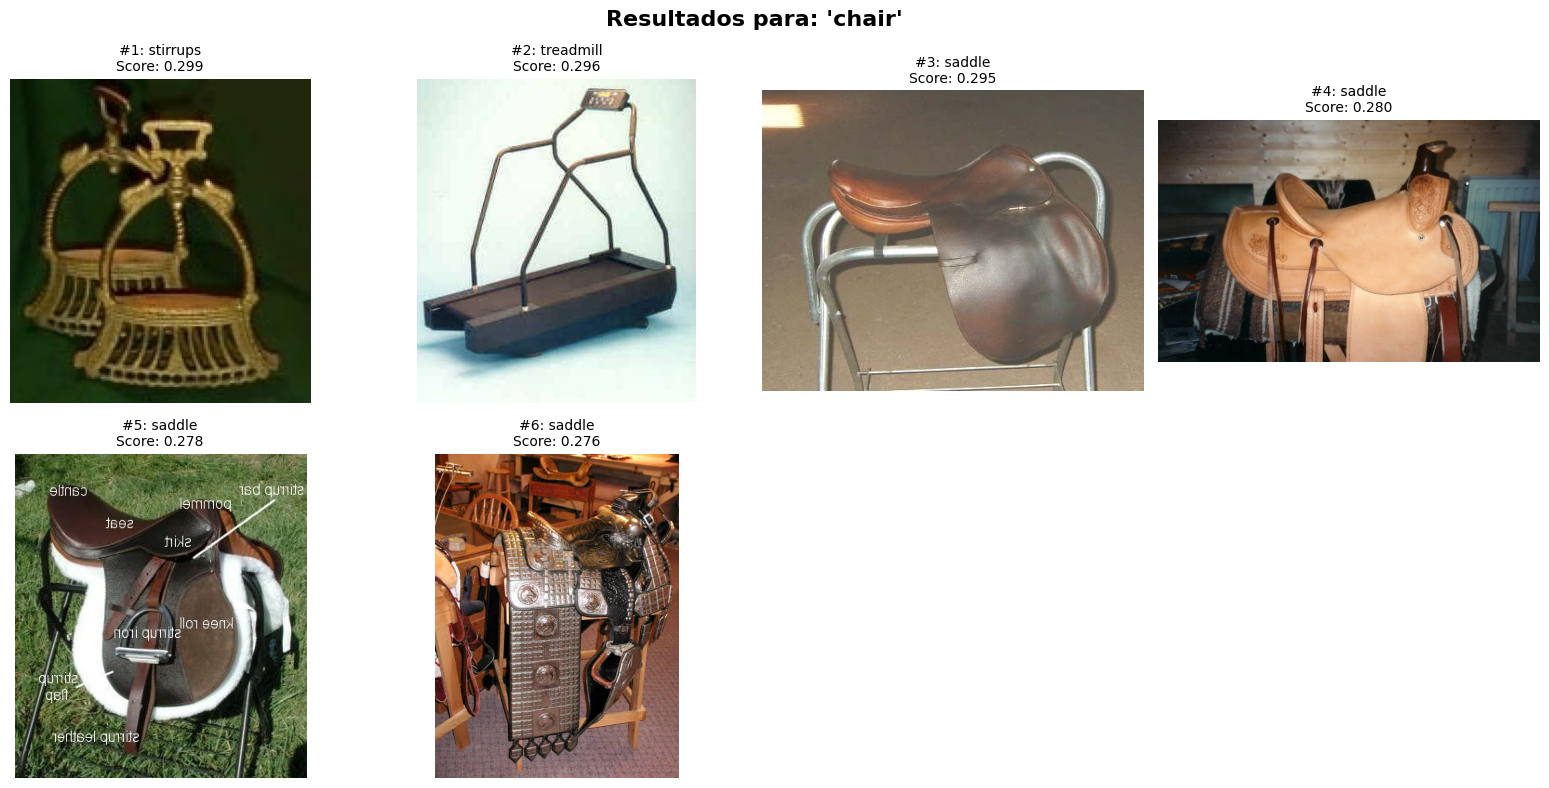

In [24]:
# Ejemplo 3: Buscar objetos del hogar
retrieval_system.search_and_visualize_text("chair", k=6)

## 7. Evaluación y Análisis del Sistema


In [26]:
# Funciones de evaluación del sistema

from evaluate import evaluate_text_search_accuracy, evaluate_image_search_consistency
# Definir consultas de prueba para evaluación
test_queries = [
    ("dog", "dog"),
    ("cat", "cat"), 
    ("car", "car"),
    ("airplane", "airplanes"),
    ("horse", "horse"),
    ("chair", "chair"),
    ("table", "table"),
    ("bicycle", "bicycle"),
    ("bird", "bird"),
    ("flower", "flower")
]

# Ejecutar evaluaciones del sistema

print("=== EVALUACIÓN DEL SISTEMA DE RECUPERACIÓN ===")

# Evaluar búsqueda por texto
print("\n1. Evaluando búsqueda por texto...")
text_evaluation = evaluate_text_search_accuracy(retrieval_system, test_queries, k=3)

# Evaluar búsqueda por imagen
print("\n2. Evaluando búsqueda por imagen...")
image_evaluation = evaluate_image_search_consistency(retrieval_system,caltech_dataset, num_tests=10, k=3)

# Resumen de resultados
print("\n" + "="*50)
print("📊 RESUMEN DE EVALUACIÓN")
print("="*50)
print(f"Búsqueda por texto:")
print(f"  - Precisión: {text_evaluation['accuracy']:.3f}")
print(f"  - Consultas procesadas: {text_evaluation['total_queries']}")
print(f"  - Predicciones correctas: {text_evaluation['correct_predictions']}")

print(f"\nBúsqueda por imagen:")
print(f"  - Consistencia promedio: {image_evaluation['avg_consistency']:.3f}")
print(f"  - Coincidencias promedio: {image_evaluation['avg_matches']:.2f}")
print(f"  - Pruebas realizadas: {image_evaluation['num_tests']}")

# Análisis detallado de búsqueda por texto
print(f"\n📋 ANÁLISIS DETALLADO DE BÚSQUEDA POR TEXTO:")
for result in text_evaluation['detailed_results']:
    status = "✅" if result['found_correct'] else "❌"
    print(f"  {status} '{result['query']}' -> Esperado: {result['expected']}, Top: {result['top_result']} (Score: {result['top_score']:.3f})")


=== EVALUACIÓN DEL SISTEMA DE RECUPERACIÓN ===

1. Evaluando búsqueda por texto...
Evaluando precisión de búsqueda por texto...
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 35.49it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 26.03it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 96.38it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 54.83it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 103.66it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 105.69it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 95.57it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 99.21it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 105.34it/s]


Embeddings de texto extraídos: (1, 512)
Extrayendo embeddings de 1 textos...


100%|██████████| 1/1 [00:00<00:00, 95.98it/s]


Embeddings de texto extraídos: (1, 512)

Resultados de evaluación:
  - Consultas procesadas: 10
  - Predicciones correctas: 3
  - Precisión: 0.300

2. Evaluando búsqueda por imagen...
Evaluando consistencia de búsqueda por imagen (10 pruebas)...
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 36.61it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 36.40it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 38.32it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 39.52it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 37.23it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 35.49it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 35.09it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 36.46it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


Embeddings de imágenes extraídos: (1, 512)
Extrayendo embeddings de 1 imágenes...


100%|██████████| 1/1 [00:00<00:00, 35.45it/s]

Embeddings de imágenes extraídos: (1, 512)

Resultados de evaluación:
  - Pruebas realizadas: 10
  - Consistencia promedio: 0.867
  - Coincidencias promedio por consulta: 2.60

📊 RESUMEN DE EVALUACIÓN
Búsqueda por texto:
  - Precisión: 0.300
  - Consultas procesadas: 10
  - Predicciones correctas: 3

Búsqueda por imagen:
  - Consistencia promedio: 0.867
  - Coincidencias promedio: 2.60
  - Pruebas realizadas: 10

📋 ANÁLISIS DETALLADO DE BÚSQUEDA POR TEXTO:
  ✅ 'dog' -> Esperado: dog, Top: fire hydrant (Score: 0.285)
  ❌ 'cat' -> Esperado: cat, Top: skunk (Score: 0.264)
  ❌ 'car' -> Esperado: car, Top: steering wheel (Score: 0.287)
  ✅ 'airplane' -> Esperado: airplanes, Top: airplanes (Score: 0.268)
  ✅ 'horse' -> Esperado: horse, Top: unicorn (Score: 0.296)
  ❌ 'chair' -> Esperado: chair, Top: stirrups (Score: 0.299)
  ❌ 'table' -> Esperado: table, Top: coffin (Score: 0.299)
  ❌ 'bicycle' -> Esperado: bicycle, Top: touring bike (Score: 0.296)
  ❌ 'bird' -> Esperado: bird, Top: ibis (Sc